# Crime in Denmark - Distributed by Country of Origin

# Setup

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import clear_output

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1) Reading and cleaning data

We start by importing the dataset from "Danmarks Statistik". We import a dataset that examines which country of origin the people who commits crime in Denmark come from. The Dataset is called "STRAFNA3"

In [11]:
import datetime

import pandas_datareader 
from dstapi import DstApi 

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})


In [12]:
ind = DstApi('STRAFNA3')

We show a summary of the data in a table to give an overview over the different variables and values in the dataset we use.

In [13]:
tabsum = ind.tablesummary(language='en')
display(tabsum)

Table STRAFNA3: Persons guilty in crimes by sex, age, country of origin and time
Last update: 2023-12-12T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,KOEN,2,M,Men,K,Women,False
1,ALDER,4,TOT,"Age, total",50-79,50-79 years,False
2,IELAND,75,0000,Total,7300,"Other countries, non-western",False
3,Tid,21,2000,2000,2022,2022,True


We then do some cleaning of the data by only having the value "TOT" for variable "ALDER" and the years we examine in this project is from 2017 until 2022. The reason for this limitation is because we only want to show how the crime in Denmark has developed in recent years.

In [14]:
# The _define_base_params -method gives us a nice template (selects all available data)
params = ind._define_base_params(language='en')
variables = params['variables'] 
variables[1]['values'] = ['TOT']
variables[3]['values'] = ['2017', '2018', '2019', '2020', '2021', '2022']
params

{'table': 'strafna3',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'KOEN', 'values': ['*']},
  {'code': 'ALDER', 'values': ['TOT']},
  {'code': 'IELAND', 'values': ['*']},
  {'code': 'Tid', 'values': ['2017', '2018', '2019', '2020', '2021', '2022']}]}

In [15]:
inc_api = ind.get_data(params=params)

We a print out a list that shows the different countries in the dataset. We see that the dataset includes:'Denmark', 'Other countries, non-western', 'Other countries, total', 'Total'. We remove these values from our data since we want to examine which specific countries of origin commits the most crime in Denmark. 

In [16]:
# Assuming you have already loaded and prepared the DataFrame inc_api

# Get the unique values from the 'IELAND' column
represented_countries = inc_api['IELAND'].unique()

# Display the list of represented countries
print("Represented Countries:")
for country in represented_countries:
    print(country)


Represented Countries:
Yugoslavia
Poland
Portugal
Romania
Switzerland
Soviet Union
Spain
United Kingdom
Turkey
Hungary
Germany
Austria
Algeria
Ethiopia
Ghana
Kenya
Morocco
Nigeria
South Africa
Tanzania
Tunisia
Uganda
Egypt
Somalia
Argentina
Brazil
Canada
Chile
USA
Afghanistan
Myanmar
Sri Lanka
India
Indonesia
Iraq
Iran
Israel
Japan
Jordan
China
Kuwait
Lebanon
Vietnam
Pakistan
Philippines
Syria
Thailand
Australia
Estonia
Latvia
Lithuania
Russia
Ukraine
Croatia
Bosnia and Herzegovina
Republic of North Macedonia
Yugoslavia, Federal Republic
Other countries, total
Other countries, western
Other countries, non-western
Total
Denmark
Finland
Iceland
Norway
Sweden
Belgium
Bulgaria
Czechoslovakia
France
Greece
Netherlands
Ireland
Italy
Serbia and Montenegro


# 2) Crime shares for different countries of origin

We show the different crime shares for the top 5 countries. We visualize it by creating a bar chart. We examine the years 2017-2022 by using a slider. We also seperate men from women by using a drop down menu

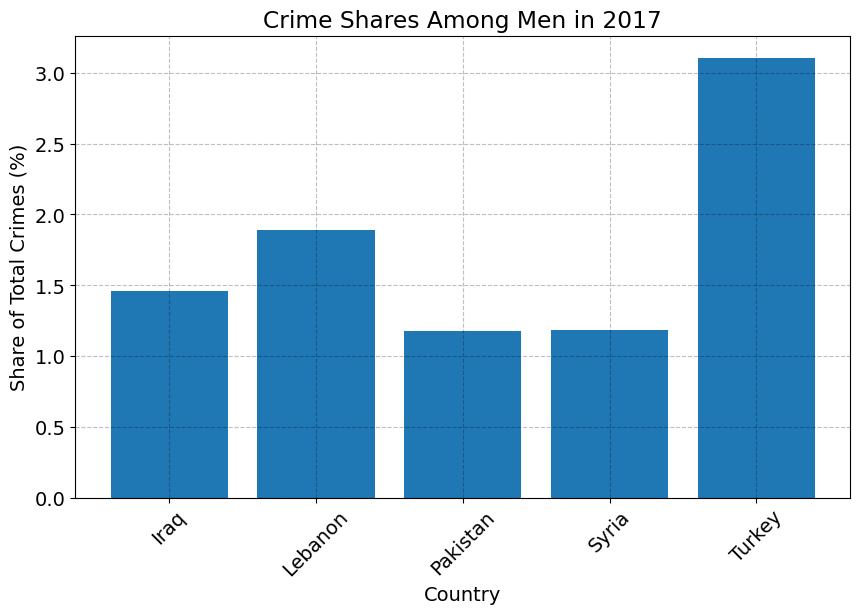

In [17]:
def plot_crime_shares(gender, year):
    # Filter data based on gender and the selected year
    total_crimes_year = inc_api[(inc_api['KOEN'] == gender) & (inc_api['TID'] == year) & (inc_api['IELAND'] == 'Total')]['INDHOLD'].sum()
    
    # Exclude specified countries
    exclude_countries = ['Denmark', 'Other countries, non-western', 'Other countries, total', 'Total']
    
    # Find top 5 countries based on 'INDHOLD' for the selected gender, excluding specified countries
    top_countries_gender = inc_api[(inc_api['KOEN'] == gender) & (inc_api['TID'] == year) & (~inc_api['IELAND'].isin(exclude_countries))].nlargest(5, 'INDHOLD')['IELAND'].tolist()
    
    filtered_data = inc_api[(inc_api['KOEN'] == gender) & (inc_api['TID'] == year) & (inc_api['IELAND'].isin(top_countries_gender))].copy()
    
    if total_crimes_year > 0:  # Ensure there's data to avoid division by zero
        filtered_data['Share'] = filtered_data['INDHOLD'] / total_crimes_year * 100
        
        # Sort the filtered data by country name
        filtered_data = filtered_data.sort_values(by='IELAND')
        
        plt.figure(figsize=(10, 6))
        plt.bar(filtered_data['IELAND'], filtered_data['Share'])
        plt.title(f'Crime Shares Among {gender} in {year}')
        plt.xlabel('Country')
        plt.ylabel('Share of Total Crimes (%)')
        plt.xticks(rotation=45)
        plt.show()

def on_controls_change(change):
    clear_output(wait=True)
    # Ensure the controls are displayed after clearing output
    display(widgets.HBox([gender_dropdown, year_slider]))
    # Update the plot based on current values of the gender dropdown and year slider
    plot_crime_shares(gender_dropdown.value, year_slider.value)

# Create a gender dropdown widget
gender_dropdown = widgets.Dropdown(options=['Men', 'Women'], description='Gender:', value='Men')

# Create a year slider widget
year_slider = widgets.IntSlider(min=2017, max=2022, step=1, description='Year:', value=2017)

# Combine the gender dropdown and year slider into a horizontal box
controls = widgets.HBox([gender_dropdown, year_slider])

# Observe changes for both widgets using the same handler
gender_dropdown.observe(on_controls_change, names='value')
year_slider.observe(on_controls_change, names='value')

# Initial display of widgets and default plot
display(controls)
plot_crime_shares(gender_dropdown.value, year_slider.value)


We can conclude by the bar chart that people with origin from Turkey and Lebanon commits the highest share of crime in Denmark

# 3) Distribution of crimes between the top 5 countries of origin

We create a circle diagram to show the distribution of crimes between the 5 countries that commits the most crime. We again seperate men from women with a drop down.

Dropdown(description='Gender:', options=('Men', 'Women'), value='Men')

IntSlider(value=2017, description='Year', max=2022, min=2017)

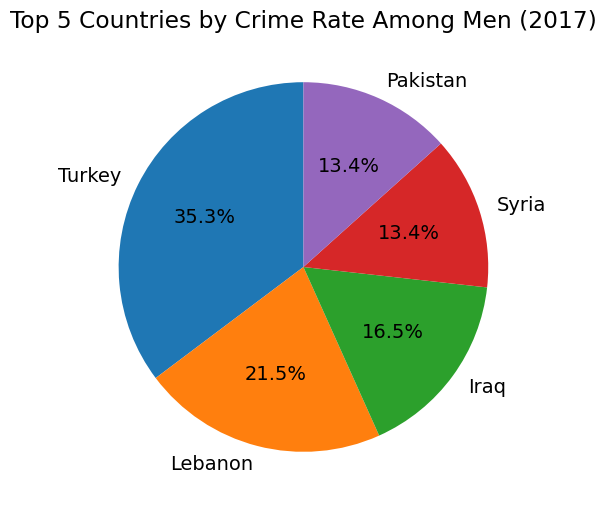

In [18]:
def plot_pie_chart(gender, selected_year):
    # Ensure you use the correct DataFrame name and column names
    filtered_data = inc_api[(inc_api['KOEN'] == gender) & 
                            (inc_api['IELAND'] != 'Total') & 
                            (inc_api['IELAND'] != 'Denmark') & 
                            (inc_api['IELAND'] != 'Other countries, non-western') & 
                            (inc_api['IELAND'] != 'Other countries, total') & 
                            (inc_api['TID'].astype(int) == selected_year)]
    top_countries = filtered_data.groupby('IELAND')['INDHOLD'].sum().nlargest(5)
    
    plt.figure(figsize=(10, 6))
    top_countries.plot(kind='pie', autopct='%1.1f%%', startangle=90, ylabel='', 
                       title=f'Top 5 Countries by Crime Rate Among {gender} ({selected_year})')
    plt.show()

def on_gender_year_selected(change):
    clear_output(wait=True)
    display(gender_dropdown)  # Redisplay the dropdown to ensure it persists after clearing the output
    display(year_slider)  # Display the year slider
    plot_pie_chart(gender_dropdown.value, year_slider.value)

gender_dropdown = widgets.Dropdown(options=['Men', 'Women'], description='Gender:')
year_slider = widgets.IntSlider(description='Year', min=2017, max=2022, value=2017)

gender_dropdown.observe(on_gender_year_selected, names='value')
year_slider.observe(on_gender_year_selected, names='value')

display(gender_dropdown)
display(year_slider)

plot_pie_chart('Men', 2017)  # Default display


It is seen by the circle diagram that Turkey commits approxiamtely 1/3 of the total crime committed by the five countries. The distribution are quite similar for both men and women.

# 4) The crime development 

Dropdown(description='Gender:', options=('Men', 'Women'), value='Men')

<Figure size 1000x600 with 0 Axes>

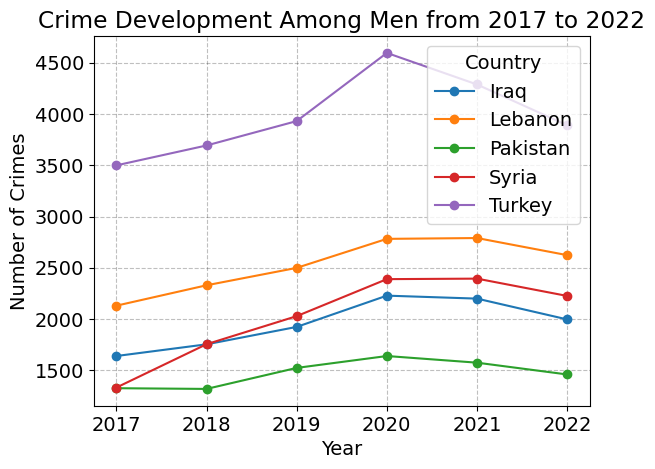

In [19]:
def plot_crime_development(gender):
    # Step 1: Filter by gender and year
    filtered_data = inc_api[(inc_api['KOEN'] == gender) & (inc_api['TID'].between(2017, 2022))]
    
    # Step 2: Define countries based on gender
    countries = []
    if gender == 'Men':
        countries = ["Turkey", "Pakistan", "Iraq", "Syria", "Lebanon"]
    elif gender == 'Women':
        countries = ["Turkey", "Pakistan", "Iraq", "Poland", "Lebanon"]
    
    # Step 3: Further filter to include only the specified countries
    filtered_data = filtered_data[filtered_data['IELAND'].isin(countries)]
    
    # Step 4: Group by country and year, then sum
    grouped_data = filtered_data.groupby(['IELAND', 'TID'])['INDHOLD'].sum().unstack()
    
    # Step 5: Plot the data
    plt.figure(figsize=(10, 6))  # Adjust the figure size for better readability
    grouped_data.T.plot(kind='line', marker='o')  # Transpose to have years on the x-axis and countries as lines
    plt.title(f'Crime Development Among {gender} from 2017 to 2022')
    plt.xlabel('Year')
    plt.ylabel('Number of Crimes')
    plt.grid(True)
    plt.legend(title='Country')
    plt.show()

def on_gender_selected(change):
    clear_output(wait=True)
    display(gender_dropdown)  # Redisplay the dropdown to ensure it persists after clearing the output
    plot_crime_development(change['new'])

gender_dropdown = widgets.Dropdown(options=['Men', 'Women'], description='Gender:')
gender_dropdown.observe(on_gender_selected, names='value')

display(gender_dropdown)
plot_crime_development('Men')  # Default display


In [20]:
oprindelse = DstApi('FOLK2')

tabsum = oprindelse.tablesummary(language='en')
display(tabsum)

Table FOLK2: Population 1. January by age, sex, ancestry, citizenship, country of origin and time
Last update: 2024-02-12T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,ALDER,126,0,0 years,125,125 years,False
1,KØN,2,M,Men,K,Women,False
2,HERKOMST,3,5,Persons of Danish origin,3,Descendant,False
3,STATSB,2,DANSK,Denmark,UDLAND,Foreign,False
4,IELAND,241,5100,Denmark,5999,Not stated,False
5,Tid,45,1980,1980,2024,2024,True


In [21]:
# The _define_base_params -method gives us a nice template (selects all available data)
params = oprindelse._define_base_params(language='en')
variables = params['variables'] 
variables[5]['values'] = ['2017', '2018', '2019', '2020', '2021', '2022']
params

{'table': 'folk2',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'ALDER', 'values': ['*']},
  {'code': 'KØN', 'values': ['*']},
  {'code': 'HERKOMST', 'values': ['*']},
  {'code': 'STATSB', 'values': ['*']},
  {'code': 'IELAND', 'values': ['*']},
  {'code': 'Tid', 'values': ['2017', '2018', '2019', '2020', '2021', '2022']}]}

In [22]:
oprindelse_api = oprindelse.get_data(params=params)

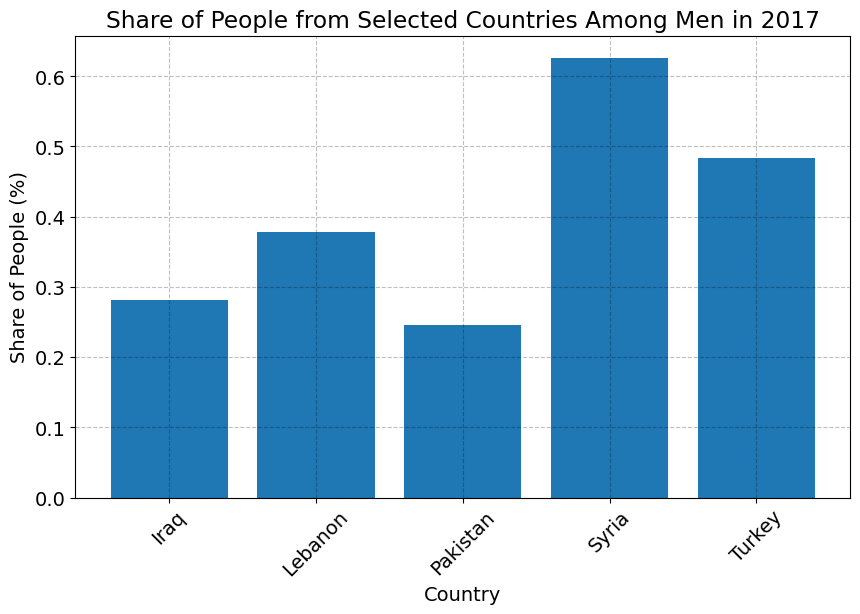

In [23]:
def plot_people_shares(year, gender):
    # Filter data based on the selected year and gender
    filtered_data = oprindelse_api[(oprindelse_api['TID'] == year) & 
                                   (oprindelse_api['KØN'] == gender)]
    
    # Define countries based on gender
    countries_of_interest = []
    if gender == 'Men':
        countries_of_interest = ['Turkey', 'Pakistan', 'Iraq', 'Syria', 'Lebanon']
    elif gender == 'Women':
        countries_of_interest = ['Turkey', 'Pakistan', 'Iraq', 'Poland', 'Lebanon']
    
    # Focus on the specified countries
    filtered_data = filtered_data[filtered_data['IELAND'].isin(countries_of_interest)]
    
    # Assuming INDHOLD contains the count or share of people
    total_people = filtered_data['INDHOLD'].sum()
    filtered_data['Share'] = (filtered_data['INDHOLD'] / total_people) * 100
    
    # Sort the filtered data by country name
    filtered_data = filtered_data.sort_values(by='IELAND')
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(filtered_data['IELAND'], filtered_data['Share'])
    plt.title(f'Share of People from Selected Countries Among {gender} in {year}')
    plt.xlabel('Country')
    plt.ylabel('Share of People (%)')
    plt.xticks(rotation=45)
    plt.show()

def on_controls_change(change):
    clear_output(wait=True)
    display(widgets.HBox([year_slider, gender_dropdown]))
    plot_people_shares(year_slider.value, gender_dropdown.value)

# Create interactive widgets
year_slider = widgets.IntSlider(min=2017, max=2022, step=1, description='Year:', value=2017)
gender_dropdown = widgets.Dropdown(options=['Men', 'Women'], description='Gender:', value='Men')

# Setup observation of widget changes
year_slider.observe(on_controls_change, names='value')
gender_dropdown.observe(on_controls_change, names='value')

# Initial display of widgets and plot
display(widgets.HBox([year_slider, gender_dropdown]))
plot_people_shares(year_slider.value, gender_dropdown.value)


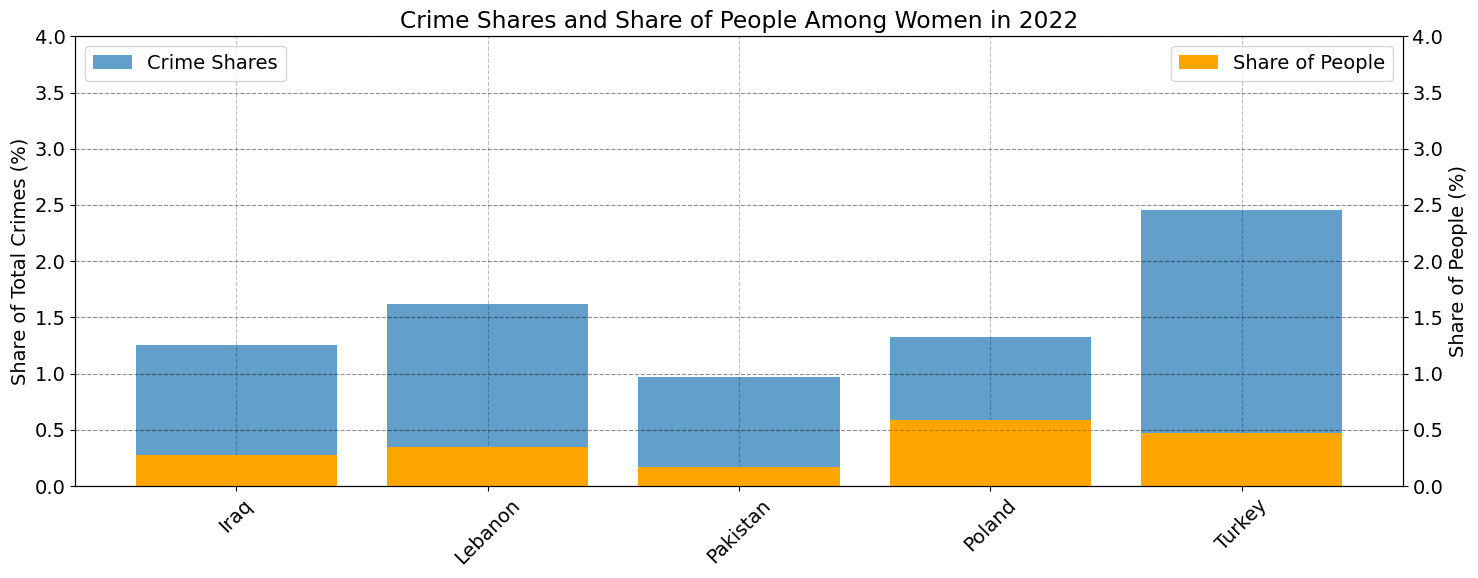

In [24]:
def plot_comparison(year, gender):
    fig, ax1 = plt.subplots(figsize=(15, 6))
    
    # Define countries based on gender
    if gender == 'Men':
        countries_of_interest = ['Turkey', 'Pakistan', 'Iraq', 'Syria', 'Lebanon']
    elif gender == 'Women':
        countries_of_interest = ['Turkey', 'Pakistan', 'Iraq', 'Poland', 'Lebanon']
    
    # Plotting crime shares
    plot_crime_shares(gender, year, ax1, countries_of_interest)
    plt.title(f'Crime Shares and Share of People Among {gender} in {year}')
    
    # Create a secondary y-axis
    ax2 = ax1.twinx()
    
    # Plotting people shares
    plot_people_shares(year, gender, ax2, countries_of_interest)
    
    plt.tight_layout()
    plt.show()

def plot_crime_shares(gender, year, ax, countries_of_interest):
    # Filter data based on gender and the selected year
    total_crimes_year = inc_api[(inc_api['KOEN'] == gender) & (inc_api['TID'] == year) & (inc_api['IELAND'] == 'Total')]['INDHOLD'].sum()
    
    filtered_data = inc_api[(inc_api['KOEN'] == gender) & (inc_api['TID'] == year) & (inc_api['IELAND'].isin(countries_of_interest))].copy()
    
    if total_crimes_year > 0:  # Ensure there's data to avoid division by zero
        filtered_data['Share'] = filtered_data['INDHOLD'] / total_crimes_year * 100
        
        # Sort the filtered data by country name
        filtered_data = filtered_data.sort_values(by='IELAND')
        
        # Plot the bars on the primary y-axis
        ax.bar(filtered_data['IELAND'], filtered_data['Share'], label='Crime Shares', alpha=0.7)  # Adjust alpha for transparency
        ax.set_ylabel('Share of Total Crimes (%)')
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylim(0, 4)  # Ensure y-axis limits are consistent between plots
        ax.legend(loc='upper left')

def plot_people_shares(year, gender, ax, countries_of_interest):
    # Filter data based on the selected year and gender
    filtered_data = oprindelse_api[(oprindelse_api['TID'] == year) & 
                                   (oprindelse_api['KØN'] == gender)]
    
    
    # Focus on the specified countries
    filtered_data = filtered_data[filtered_data['IELAND'].isin(countries_of_interest)]
    
    # Assuming INDHOLD contains the count or share of people
    total_people = filtered_data['INDHOLD'].sum()
    filtered_data['Share'] = (filtered_data['INDHOLD'] / total_people) * 100
    
    # Sort the filtered data by country name
    filtered_data = filtered_data.sort_values(by='IELAND')
    
    # Plot the bars on the secondary y-axis
    ax.bar(filtered_data['IELAND'], filtered_data['Share'], label='Share of People', alpha=1, color='orange')  # Adjust alpha for transparency
    ax.set_ylabel('Share of People (%)')
    ax.set_ylim(0, 4)  # Ensure y-axis limits are consistent between plots
    ax.legend(loc='upper right')

def on_controls_change(change):
    clear_output(wait=True)
    display(widgets.HBox([year_slider, gender_dropdown]))
    plot_comparison(year_slider.value, gender_dropdown.value)

# Create interactive widgets
year_slider = widgets.IntSlider(min=2017, max=2022, step=1, description='Year:', value=2017)
gender_dropdown = widgets.Dropdown(options=['Men', 'Women'], description='Gender:', value='Men')

# Setup observation of widget changes
year_slider.observe(on_controls_change, names='value')
gender_dropdown.observe(on_controls_change, names='value')

# Initial display of widgets and plot
display(widgets.HBox([year_slider, gender_dropdown]))
plot_comparison(year_slider.value, gender_dropdown.value)